# Relevance Vector Regression

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from __future__ import print_function

%matplotlib inline
np.random.seed(123)

def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

## Имплементация Relevance Vector Regression

Здесь необходимо реализовать три функции:

1. `get_w_sigma(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и возвращает параметры апостериорного распределения mu, sigma
2. `update_alpha_beta(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и делает один шаг итерационной процедуры для обновления гиперпараметров (было на лекции)
3. `fit_rvr(X, t, max_iters)`, которая принимает датасет (X, t) и максимальное количество итераций и возвращает обученные гиперпараметры и параметры апостериорного распределения на веса модели

На что стоит обратить внимание:

1. Результаты дорогостоящих операций типа перемножения одних и тех же матриц нужно кешировать и переиспользовать
2. $\alpha$-ы для нерелевантных объектов должны принять значение `np.inf`, а соответствующие веса и их дисперсии должны иметь значение 0
3. Бесконечности и нули из предыдущего пункта должны обрабатываться корректно, без NaN-ов и warning-ов
4. Матрицу с бесконечными элементами на диагонали можно обращать более эффективно (достаточно обратить подматрицу)

In [3]:

def get_w_sigma(X, t, alpha, beta):
    """Calculate the mean and the covariance matrix
       of the posterior distribution"""
    n, d = X.shape
    matrix = beta.dot(X)+alpha

    idx_1 = np.where(matrix == np.inf)
    matr = matrix.copy()
    for i in range(idx_1[0].shape[0]):
      a = np.array([np.inf]*alpha.shape[0])
      matrix[idx_1[0][i]] = a
      matrix[:, idx_1[1][i]] = a
    idx_2 = np.where(matrix != np.inf)
    matr = np.delete(matr, idx_1[0], axis=0)
    matr = np.delete(matr, idx_1[1], axis=1) 
    matr_inv = np.linalg.inv(matr)
    k = 0
    for i in range(matr_inv.shape[0]):
      for j in range(matr_inv.shape[1]):
        matrix[idx_2[0][k]][idx_2[1][k]] = matr_inv[i][j]
        k+=1
    matrix[np.where(matrix == np.inf)] = 0
    sigma = matrix

    w = beta.dot(sigma.dot(t))
    return w, sigma


def update_alpha_beta(X, t, alpha, beta, X_X, X_t):
    """Update the hyperperemeters to increase evidence"""
    
    # YOUR CODE GOES HERE
    w, sigma = get_w_sigma(X_X, X_t, alpha, beta)
    alpha_new = alpha.copy()
    
    k = 0 
    for i in range(alpha.shape[0]):
      if (alpha_new[i][i] >= 1e12):
        alpha_new[i][i] = np.inf
        w[i] = 0
        sigma[i][i] = 0
        k+=0
      else:
        alpha_new[i][i] = (1 - alpha[i][i]*sigma[i][i])/(w[i]**2)
        k+=1-alpha[i][i]*sigma[i][i]
  
    beta_new = ((alpha.shape[0] - k)/(np.linalg.norm(t - X.dot(w)))**2) * np.eye(beta.shape[0])
    
    return alpha_new, beta_new


def fit_rvr(X, t, max_iter=10000):
    """Train the Relevance Vector Regression model"""
    # YOUR CODE GOES HERE
    alpha = (0.01)*np.eye(X.shape[1])
    beta = (0.01)*np.eye(X.shape[1])
    X_X = (X.T).dot(X)
    X_t = (X.T).dot(t)
    for i in range(max_iter):
      alpha, beta = update_alpha_beta(X, t, alpha, beta, X_X, X_t)
      if (np.isnan(alpha[1])[1]):
        break
    w, sigma = get_w_sigma(X_X, X_t, alpha, beta)
    for i in range(len(alpha)):
      l = np.array([np.inf]*alpha.shape[0])
      l[i] = alpha[i][i]
      alpha[i] = l
    return w, sigma, alpha, beta


## Восстановление полинома

Здесь решается модельная задача: зашумленным полиномом третьей степени сгенерированы данные для задачи регрессии. Нужно на этих данных обучить многочлен степени, не превышающей 20. Предлагается сравнить три модели: гребневую регрессию, L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных признаков.

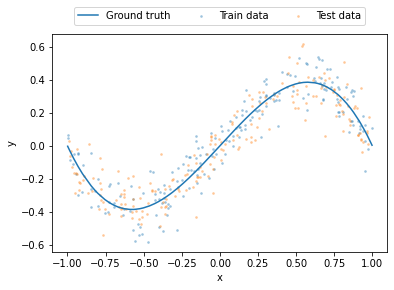

In [21]:
# Data generation

def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-1, 1, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

n = 200
d = 21
w_true = np.zeros(d)
w_true[1] = 1
w_true[3] = -1
beta_true = 100

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

# Visualization
fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [22]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

In [23]:
# Ridge Regression with Cross-Validation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(cv=20, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False).fit(X_train, t_train)
w_ridge = ridge.coef_

In [24]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV, Lasso
lasso = LassoCV(cv=5, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False, max_iter=2000000).fit(X_train, t_train)
w_lasso = lasso.coef_

Relevance Vector Regression
Features remaining: 2 / 21
Train error: 0.008770274623064747
Test error:  0.009961051997637688
--------------------------------------------------
Ridge Regression
Features remaining: NA (no sparsity)
Train error: 0.008613889305590814
Test error:  0.010339109099203
--------------------------------------------------
Lasso Regression
Features remaining: 9 / 21
Train error: 0.008563901954483723
Test error:  0.010221106597958536


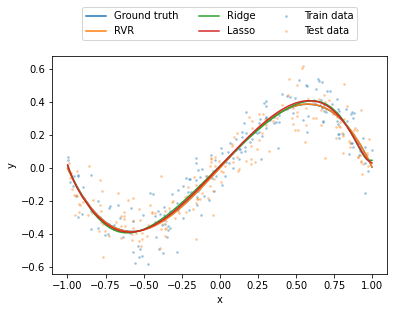

In [25]:
# Comparison
print('Relevance Vector Regression')
print('Features remaining:', np.sum(alpha_rvr < 1e8), '/', d)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Ridge Regression')
print('Features remaining: NA (no sparsity)')
print('Train error:', l2_error(X_train, t_train, w_ridge) / n)
print('Test error: ', l2_error(X_test, t_test, w_ridge) / n)
print('-'*50)
print('Lasso Regression')
print('Features remaining:', np.sum(np.abs(w_lasso) > 1e-20), '/', d)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)

fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')
ax.plot(X_train[:, 1], X_train.dot(w_rvr), label='RVR')
ax.plot(X_train[:, 1], X_train.dot(w_ridge), label='Ridge')
ax.plot(X_train[:, 1], X_train.dot(w_lasso), label='Lasso')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Регрессия с RBF-признаками

Здесь решается другая модельная задача: необходимо восстановить зашумленную функцию `sinc(x)`. Предлагается применить kernel trick с RBF-ядром (можно использовать функцию `sklearn.metrics.pairwise.rbf_kernel`), обучить три модели: SVM-регрессию (SVR), L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных опорных / релевантных объектов.

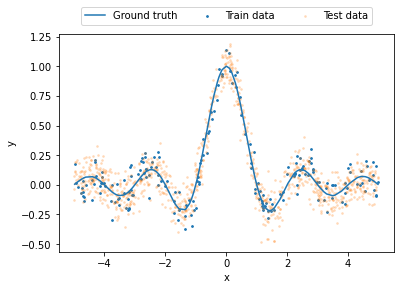

In [27]:
# Data generation
from sklearn.metrics.pairwise import rbf_kernel

def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t

n = 200
n_test = 1000
d = n + 1
beta_true = 100

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n_test, beta_true)

X_train = rbf_kernel(points_train.reshape(points_train.shape[0],1), points_train.reshape(points_train.shape[0],1)) 
X_test = rbf_kernel(points_test.reshape(points_test.shape[0],1), points_train.reshape(points_train.shape[0],1)) 

# Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n_test, 1)), X_test))

# Visualization
fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=1)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.2)
ax.plot(points_train, np.sinc(points_train), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [33]:
print((l2_error(X_test, t_test, w_rvr) - l2_error(X_train, t_train, w_rvr))/n)
print((l2_error(X_test, t_test, w_lasso) - l2_error(X_train, t_train, w_lasso))/ n)
print((np.sum((svr.predict(points_test.reshape(-1, 1)) - t_test) ** 2) - np.sum((svr.predict(points_train.reshape(-1, 1)) - t_train) ** 2) )/n)

0.05097901255806275
0.04969818753145638
0.050545794095788736


In [28]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

In [29]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=10, alphas=10.**np.linspace(-5, 1, 20),
                fit_intercept=False, max_iter=100000, tol=1e-2, n_jobs=10).fit(X_train, t_train) #max_iter = 100000 tol = 1e-2
w_lasso = lasso.coef_

In [30]:
# Support Vector Regression
from sklearn.svm import SVR
svr = SVR(gamma=1, tol=1e-6, C=1).fit(points_train.reshape(-1, 1), t_train)  #tol=1e-6

Relevance Vector Regression
Objects remaining: 9 / 200
Train error: 0.008694227969357454
Test error:  0.0596732405274202
--------------------------------------------------
Lasso Regression
Objects remaining: 125 / 200
Train error: 0.008496003278915676
Test error:  0.058194190810372054
--------------------------------------------------
Support Vector Regression
Objects remaining: 61 / 200
Train error: 0.008415482883222063
Test error:  0.058961276979010796


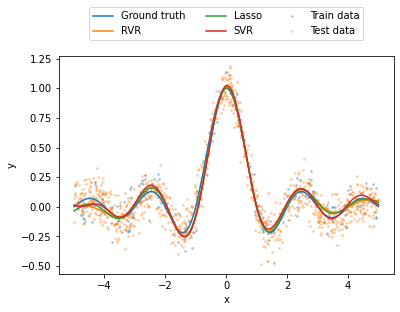

In [31]:
# Comparison
print('Relevance Vector Regression')
print('Objects remaining:', np.sum(alpha_rvr[1:] < 1e8), '/', n)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Lasso Regression')
print('Objects remaining:', np.sum(np.abs(w_lasso[1:]) > 1e-20), '/', n)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)
print('-'*50)
print('Support Vector Regression')
print('Objects remaining:', len(svr.support_), '/', n)
print('Train error:', np.sum((svr.predict(points_train.reshape(-1, 1)) - t_train) ** 2) / n)
print('Test error: ', np.sum((svr.predict(points_test.reshape(-1, 1)) - t_test) ** 2) / n)

fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.plot(points_test, X_test.dot(w_rvr), label='RVR')
ax.plot(points_test, X_test.dot(w_lasso), label='Lasso')
ax.plot(points_test, svr.predict(points_test.reshape(-1, 1)), label='SVR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

### Визуализация релевантных объектов для RVR

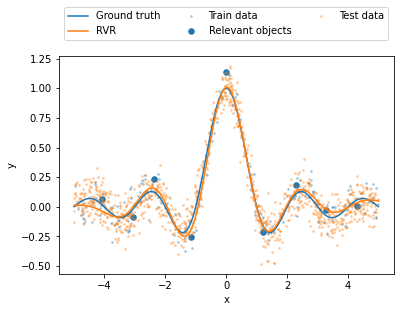

In [32]:
relevant = alpha_rvr[1:] < 1e8
fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_train[np.where(relevant == True)[0]], t_train[np.where(relevant == True)[0]], c='tab:blue', s=30, label='Relevant objects')
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.plot(points_test, X_test.dot(w_rvr), label='RVR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Выводы
В этом поле опишите свои наблюдения и сформулируйте свои выводы

В 1 эксперименте мы сранивали его с L1-регрессией, гребневой регрессией. Во 2 эксперименте мы использовали ядровые функции в качестве признаков, в результате чего время обучения сильно выросло, и сравнивали с L1-регрессией и SVM-регрессией. 
Заметим, что в первом эксперименте RVR оставила всего 2 признака, а L1-регрессия - 9 признака, во втором эксперименте RVR отобрала 9 релевантных объектов, в то время, когда L1-регрессия - 80 и SVM-регрессия - 66 объектов, в результате чего можно сказать, что RVR более тщательно отбирает релевантные объекты и признаки. Но в тоже время RVR работает медленее SVM-регрессии из-за того, что на каждой итерации приходится обращать матрицу. 
